# Hypothesis testing

- One factor, more than two treatments

- factor: config -> EP_runtime
- treatments: [GPUEP, CPUEP] * [torch, onnx, ov, torchscript]
-----------------
- Input:
  - cpu*/tables/final_*.csv, gpu*/tables/final_*.csv
  - 
- Output:
  - results_tests/[test]...  :results of statistical tests by model
 
- first to define global_df: energy, nvidia,.. inference time


- run {script name}.py to fgo through all experiment runs

## Set env

In [105]:
import os
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import scikit_posthocs as sp
import seaborn as sns
#from cliffs_delta import cliffs_delta
from scipy import stats

#from src.data.analysis import test_assumptions, boxplot, barplot, eta_squared, is_pareto_efficient, print_improvement
#from src.environment import FIGURES_DIR, METRICS_DIR
#from src.data.preprocessing import GJOULES_TO_KJOULES, HOURS_TO_MILISECONDS



sns.set_theme(palette="colorblind", color_codes=True)

%matplotlib inline

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "Times New Roman"
mpl.rcParams["font.weight"] = "bold"
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.autolayout"] = "true"

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools  # for cycling through colors if necessary
import glob
import re
import os

from scipy.stats import shapiro
from scipy.stats import levene

In [107]:
#num_models = 5 #CHANGE
#device = 'gpu'
#path = f"D:/GAISSA/energy-repo/last_repo/june_{device}/"  # Adjust this path to your CSV files location #CHANGE

save_dir = f"D:/GAISSA/energy-repo/last_repo/results_tests_x/" 
general_dir = f"D:/GAISSA/energy-repo/last_repo/" 

#new_directory = f"D:/GAISSA/energy-repo/last_repo/june_{device}_test/" # change
#new_results = f"D:/GAISSA/energy-repo/last_repo/{device}_june_phi2_01/" # change
#os.chdir(new_directory)


In [108]:
SAVE_TABLES = False
SAVE_FIGS = False

In [109]:
# configs =['torch_pythia1-4b', 'torch_tinyllama',
#        'torch_codeparrot-small', 'torch_pythia-410m', 'onnx_pythia1-4b',
#        'onnx_tinyllama', 'onnx_codeparrot-small', 'onnx_pythia-410m',
#        'torchscript_pythia1-4b', 'torchscript_tinyllama',
#        'torchscript_codeparrot-small', 'torchscript_pythia-410m']

In [110]:
try:
    os.mkdir(save_dir )
except Exception as e:
    print("could not create directory "+ save_dir )
    print(e)

could not create directory D:/GAISSA/energy-repo/last_repo/results_tests_x/
[WinError 183] Cannot create a file when that file already exists: 'D:/GAISSA/energy-repo/last_repo/results_tests_x/'


In [111]:
# save_dir = path+"tests/"


# try:
#     os.mkdir(save_dir)
# except Exception as e:
#     print("could not create directory "+ save_dir )
#     print(e)


In [112]:
def remove_condition_rows(condition_to_remove,df):
    # example: condition = merged_df['label']  == 'idle_idle'
    df1 = df.copy()
    return df1[~condition_to_remove]

In [113]:
def save_latex_table(df,save_dir):
    df = df.copy()
    df.columns = [col.replace('_', ' ') for col in df.columns]
    
    latex_table = df.to_latex(index=False)

    # Define the filename
    filename = save_dir
    
    # Open the file in write mode
    if SAVE_TABLES:
        with open(filename, 'w') as file:
            file.write(latex_table) if SAVE_TABLES else print(f"SAVE_TABLES:{SAVE_TABLES}")
        
    # Print LaTeX table
    print(latex_table)

## DV from CPU and GPU

### Energy

In [65]:
cpu_global_energy = pd.read_csv("D:/GAISSA/energy-repo/last_repo/june_cpu/tables/final_energy_data.csv", index_col=None, header=0)
gpu_global_energy = pd.read_csv("D:/GAISSA/energy-repo/last_repo/june_gpu_test/tables/final_energy_data.csv", index_col=None, header=0)


In [66]:
print(len(cpu_global_energy['label'].unique()))
print(cpu_global_energy['label'].unique())

print(len(gpu_global_energy['label'].unique()))
print(gpu_global_energy['label'].unique())


21
['idle_idle' 'onnx_codeparrot-small' 'onnx_phi2' 'onnx_pythia-410m'
 'onnx_pythia1-4b' 'onnx_tinyllama' 'ov_codeparrot-small' 'ov_phi2'
 'ov_pythia-410m' 'ov_pythia1-4b' 'ov_tinyllama' 'torch_codeparrot-small'
 'torch_phi2' 'torch_pythia-410m' 'torch_pythia1-4b' 'torch_tinyllama'
 'torchscript_codeparrot-small' 'torchscript_phi2'
 'torchscript_pythia-410m' 'torchscript_pythia1-4b'
 'torchscript_tinyllama']
16
['idle_idle' 'onnx_codeparrot-small' 'onnx_phi2' 'onnx_pythia-410m'
 'onnx_pythia1-4b' 'onnx_tinyllama' 'torch_codeparrot-small' 'torch_phi2'
 'torch_pythia-410m' 'torch_pythia1-4b' 'torch_tinyllama'
 'torchscript_codeparrot-small' 'torchscript_phi2'
 'torchscript_pythia-410m' 'torchscript_pythia1-4b'
 'torchscript_tinyllama']


In [67]:
condition = cpu_global_energy['label'].str.endswith('idle')
cpu_global_energy = remove_condition_rows( condition, cpu_global_energy)

condition = gpu_global_energy['label'].str.endswith('idle')
gpu_global_energy = remove_condition_rows( condition, gpu_global_energy)

print(len(cpu_global_energy['label'].unique()))
print(len(gpu_global_energy['label'].unique()))

20
15


In [68]:
cpu_global_energy.head()

,label,experiment,CPU_energy,GPU_energy,global_energy
10,onnx_codeparrot-small,1,27312.755203,7697.584404,35010.339607
11,onnx_codeparrot-small,2,31829.478668,12712.752411,44542.231079
12,onnx_codeparrot-small,3,29088.745850,9962.477919,39051.223769
13,onnx_codeparrot-small,4,27174.364288,7835.923271,35010.287559
14,onnx_codeparrot-small,5,32294.745590,12847.023003,45141.768593


In [69]:
gpu_global_energy.head()

,label,experiment,CPU_energy,GPU_energy,global_energy
10,onnx_codeparrot-small,1,9036.891785,15938.552931,24975.444716
11,onnx_codeparrot-small,2,9084.025162,13823.850824,22907.875986
12,onnx_codeparrot-small,3,9111.532288,13896.811929,23008.344217
13,onnx_codeparrot-small,4,9020.099411,16083.457295,25103.556706
14,onnx_codeparrot-small,5,9020.016876,13918.800235,22938.817112


In [70]:
cpu_global_energy['config'] = "cpuep_"+cpu_global_energy['label']
cpu_global_energy

,label,experiment,CPU_energy,GPU_energy,global_energy,config
10,onnx_codeparrot-small,1,27312.755203,7697.584404,35010.339607,cpuep_onnx_codeparrot-small
11,onnx_codeparrot-small,2,31829.478668,12712.752411,44542.231079,cpuep_onnx_codeparrot-small
12,onnx_codeparrot-small,3,29088.745850,9962.477919,39051.223769,cpuep_onnx_codeparrot-small
13,onnx_codeparrot-small,4,27174.364288,7835.923271,35010.287559,cpuep_onnx_codeparrot-small
14,onnx_codeparrot-small,5,32294.745590,12847.023003,45141.768593,cpuep_onnx_codeparrot-small
...,...,...,...,...,...,...
205,torchscript_tinyllama,6,11292.901901,1929.084494,13221.986395,cpuep_torchscript_tinyllama
206,torchscript_tinyllama,7,11275.560516,1923.520505,13199.081021,cpuep_torchscript_tinyllama
207,torchscript_tinyllama,8,11315.556534,1892.603001,13208.159535,cpuep_torchscript_tinyllama
208,torchscript_tinyllama,9,11278.999252,1923.929447,13202.928699,cpuep_torchscript_tinyllama


In [71]:
gpu_global_energy['config'] = "gpuep_"+gpu_global_energy['label']
gpu_global_energy

,label,experiment,CPU_energy,GPU_energy,global_energy,config
10,onnx_codeparrot-small,1,9036.891785,15938.552931,24975.444716,gpuep_onnx_codeparrot-small
11,onnx_codeparrot-small,2,9084.025162,13823.850824,22907.875986,gpuep_onnx_codeparrot-small
12,onnx_codeparrot-small,3,9111.532288,13896.811929,23008.344217,gpuep_onnx_codeparrot-small
13,onnx_codeparrot-small,4,9020.099411,16083.457295,25103.556706,gpuep_onnx_codeparrot-small
14,onnx_codeparrot-small,5,9020.016876,13918.800235,22938.817112,gpuep_onnx_codeparrot-small
...,...,...,...,...,...,...
155,torchscript_tinyllama,6,2479.216080,7022.551625,9501.767705,gpuep_torchscript_tinyllama
156,torchscript_tinyllama,7,2528.263107,7052.688061,9580.951168,gpuep_torchscript_tinyllama
157,torchscript_tinyllama,8,2645.645905,6716.034659,9361.680564,gpuep_torchscript_tinyllama
158,torchscript_tinyllama,9,2569.570862,7063.159418,9632.730280,gpuep_torchscript_tinyllama


In [72]:
global_df = pd.concat([gpu_global_energy,cpu_global_energy], axis=0, ignore_index=True)
global_df

,label,experiment,CPU_energy,GPU_energy,global_energy,config
0,onnx_codeparrot-small,1,9036.891785,15938.552931,24975.444716,gpuep_onnx_codeparrot-small
1,onnx_codeparrot-small,2,9084.025162,13823.850824,22907.875986,gpuep_onnx_codeparrot-small
2,onnx_codeparrot-small,3,9111.532288,13896.811929,23008.344217,gpuep_onnx_codeparrot-small
3,onnx_codeparrot-small,4,9020.099411,16083.457295,25103.556706,gpuep_onnx_codeparrot-small
4,onnx_codeparrot-small,5,9020.016876,13918.800235,22938.817112,gpuep_onnx_codeparrot-small
...,...,...,...,...,...,...
345,torchscript_tinyllama,6,11292.901901,1929.084494,13221.986395,cpuep_torchscript_tinyllama
346,torchscript_tinyllama,7,11275.560516,1923.520505,13199.081021,cpuep_torchscript_tinyllama
347,torchscript_tinyllama,8,11315.556534,1892.603001,13208.159535,cpuep_torchscript_tinyllama
348,torchscript_tinyllama,9,11278.999252,1923.929447,13202.928699,cpuep_torchscript_tinyllama


### Energibridge: dependent variables

In [17]:
cpu_ep_data = pd.read_csv("D:/GAISSA/energy-repo/last_repo/june_cpu/tables/final_energibridge_data.csv", index_col=None, header=0)
gpu_ep_data = pd.read_csv("D:/GAISSA/energy-repo/last_repo/june_gpu_test/tables/final_energibridge_data.csv", index_col=None, header=0)
print(len(cpu_ep_data))
print(len(gpu_ep_data))


1635237
209652


In [18]:
print(len(cpu_ep_data['label'].unique()))
print(cpu_ep_data['label'].unique())

print(len(gpu_ep_data['label'].unique()))
print(gpu_ep_data['label'].unique())


21
['idle_idle' 'torch_pythia1-4b' 'torch_tinyllama' 'torch_codeparrot-small'
 'torch_pythia-410m' 'torch_phi2' 'onnx_pythia1-4b' 'onnx_tinyllama'
 'onnx_codeparrot-small' 'onnx_pythia-410m' 'onnx_phi2'
 'torchscript_pythia1-4b' 'torchscript_tinyllama'
 'torchscript_codeparrot-small' 'torchscript_pythia-410m'
 'torchscript_phi2' 'ov_pythia1-4b' 'ov_tinyllama' 'ov_codeparrot-small'
 'ov_pythia-410m' 'ov_phi2']
16
['idle_idle' 'torch_pythia1-4b' 'torch_tinyllama' 'torch_codeparrot-small'
 'torch_pythia-410m' 'onnx_pythia1-4b' 'onnx_tinyllama'
 'onnx_codeparrot-small' 'onnx_pythia-410m' 'torchscript_pythia1-4b'
 'torchscript_tinyllama' 'torchscript_codeparrot-small'
 'torchscript_pythia-410m' 'onnx_phi2' 'torch_phi2' 'torchscript_phi2']


In [19]:
condition = cpu_ep_data['label'].str.endswith('idle')
cpu_ep_data = remove_condition_rows( condition, cpu_ep_data)

condition = gpu_ep_data['label'].str.endswith('idle')
gpu_ep_data = remove_condition_rows( condition, gpu_ep_data)

print(len(cpu_ep_data['label'].unique()))
print(len(gpu_ep_data['label'].unique()))

20
15


In [20]:
print(cpu_ep_data.columns)
print(gpu_ep_data.columns)


Index(['label', 'experiment', 'avg_cpu_usage_config', 'avg_USED_MEMORY',
       'avg_used_memory_pct_config'],
      dtype='object')
Index(['label', 'experiment', 'avg_cpu_usage_config', 'avg_USED_MEMORY',
       'avg_used_memory_pct_config'],
      dtype='object')


In [21]:
cpu_ep_data

,label,experiment,avg_cpu_usage_config,avg_USED_MEMORY,avg_used_memory_pct_config
1500,torch_pythia1-4b,1,45.008471,9.372691e+09,14.078193
1501,torch_pythia1-4b,1,45.008471,9.372691e+09,14.078193
1502,torch_pythia1-4b,1,45.008471,9.372691e+09,14.078193
1503,torch_pythia1-4b,1,45.008471,9.372691e+09,14.078193
1504,torch_pythia1-4b,1,45.008471,9.372691e+09,14.078193
...,...,...,...,...,...
1635232,ov_phi2,9,44.331846,1.216167e+10,18.267368
1635233,ov_phi2,9,44.331846,1.216167e+10,18.267368
1635234,ov_phi2,9,44.331846,1.216167e+10,18.267368
1635235,ov_phi2,9,44.331846,1.216167e+10,18.267368


In [22]:
dependent_variables = ['avg_cpu_usage_config','avg_used_memory_pct_config']

In [23]:
cpu_ep_data = cpu_ep_data.groupby(['label', 'experiment'])[dependent_variables].mean().reset_index()
cpu_ep_data

,label,experiment,avg_cpu_usage_config,avg_used_memory_pct_config
0,onnx_codeparrot-small,1,27.027103,14.540917
1,onnx_codeparrot-small,2,16.233374,15.128038
2,onnx_codeparrot-small,3,20.517611,16.745827
3,onnx_codeparrot-small,4,27.206271,12.061013
4,onnx_codeparrot-small,5,16.006242,13.807703
...,...,...,...,...
195,torchscript_tinyllama,6,32.921949,27.609231
196,torchscript_tinyllama,7,31.990836,29.665568
197,torchscript_tinyllama,8,32.219337,29.516472
198,torchscript_tinyllama,9,31.752156,26.598737


In [24]:
gpu_ep_data = gpu_ep_data.groupby(['label', 'experiment'])[dependent_variables].mean().reset_index()
gpu_ep_data

,label,experiment,avg_cpu_usage_config,avg_used_memory_pct_config
0,onnx_codeparrot-small,1,4.025152,8.379774
1,onnx_codeparrot-small,2,3.970551,8.217921
2,onnx_codeparrot-small,3,3.976707,7.283402
3,onnx_codeparrot-small,4,3.998502,7.285040
4,onnx_codeparrot-small,5,3.857922,7.520109
...,...,...,...,...
145,torchscript_tinyllama,6,0.519750,10.764794
146,torchscript_tinyllama,7,0.535989,10.765576
147,torchscript_tinyllama,8,0.554561,13.816070
148,torchscript_tinyllama,9,0.506095,13.619581


In [25]:
cpu_ep_data['config'] = "cpuep_"+cpu_ep_data['label']
cpu_ep_data

,label,experiment,avg_cpu_usage_config,avg_used_memory_pct_config,config
0,onnx_codeparrot-small,1,27.027103,14.540917,cpuep_onnx_codeparrot-small
1,onnx_codeparrot-small,2,16.233374,15.128038,cpuep_onnx_codeparrot-small
2,onnx_codeparrot-small,3,20.517611,16.745827,cpuep_onnx_codeparrot-small
3,onnx_codeparrot-small,4,27.206271,12.061013,cpuep_onnx_codeparrot-small
4,onnx_codeparrot-small,5,16.006242,13.807703,cpuep_onnx_codeparrot-small
...,...,...,...,...,...
195,torchscript_tinyllama,6,32.921949,27.609231,cpuep_torchscript_tinyllama
196,torchscript_tinyllama,7,31.990836,29.665568,cpuep_torchscript_tinyllama
197,torchscript_tinyllama,8,32.219337,29.516472,cpuep_torchscript_tinyllama
198,torchscript_tinyllama,9,31.752156,26.598737,cpuep_torchscript_tinyllama


In [26]:
gpu_ep_data['config'] = "gpuep_"+gpu_ep_data['label']
gpu_ep_data

,label,experiment,avg_cpu_usage_config,avg_used_memory_pct_config,config
0,onnx_codeparrot-small,1,4.025152,8.379774,gpuep_onnx_codeparrot-small
1,onnx_codeparrot-small,2,3.970551,8.217921,gpuep_onnx_codeparrot-small
2,onnx_codeparrot-small,3,3.976707,7.283402,gpuep_onnx_codeparrot-small
3,onnx_codeparrot-small,4,3.998502,7.285040,gpuep_onnx_codeparrot-small
4,onnx_codeparrot-small,5,3.857922,7.520109,gpuep_onnx_codeparrot-small
...,...,...,...,...,...
145,torchscript_tinyllama,6,0.519750,10.764794,gpuep_torchscript_tinyllama
146,torchscript_tinyllama,7,0.535989,10.765576,gpuep_torchscript_tinyllama
147,torchscript_tinyllama,8,0.554561,13.816070,gpuep_torchscript_tinyllama
148,torchscript_tinyllama,9,0.506095,13.619581,gpuep_torchscript_tinyllama


In [27]:
global_df = pd.concat([cpu_ep_data,gpu_ep_data], axis=0, ignore_index=True)
print(global_df['config'].unique())
global_df

['cpuep_onnx_codeparrot-small' 'cpuep_onnx_phi2' 'cpuep_onnx_pythia-410m'
 'cpuep_onnx_pythia1-4b' 'cpuep_onnx_tinyllama'
 'cpuep_ov_codeparrot-small' 'cpuep_ov_phi2' 'cpuep_ov_pythia-410m'
 'cpuep_ov_pythia1-4b' 'cpuep_ov_tinyllama' 'cpuep_torch_codeparrot-small'
 'cpuep_torch_phi2' 'cpuep_torch_pythia-410m' 'cpuep_torch_pythia1-4b'
 'cpuep_torch_tinyllama' 'cpuep_torchscript_codeparrot-small'
 'cpuep_torchscript_phi2' 'cpuep_torchscript_pythia-410m'
 'cpuep_torchscript_pythia1-4b' 'cpuep_torchscript_tinyllama'
 'gpuep_onnx_codeparrot-small' 'gpuep_onnx_phi2' 'gpuep_onnx_pythia-410m'
 'gpuep_onnx_pythia1-4b' 'gpuep_onnx_tinyllama'
 'gpuep_torch_codeparrot-small' 'gpuep_torch_phi2'
 'gpuep_torch_pythia-410m' 'gpuep_torch_pythia1-4b'
 'gpuep_torch_tinyllama' 'gpuep_torchscript_codeparrot-small'
 'gpuep_torchscript_phi2' 'gpuep_torchscript_pythia-410m'
 'gpuep_torchscript_pythia1-4b' 'gpuep_torchscript_tinyllama']


,label,experiment,avg_cpu_usage_config,avg_used_memory_pct_config,config
0,onnx_codeparrot-small,1,27.027103,14.540917,cpuep_onnx_codeparrot-small
1,onnx_codeparrot-small,2,16.233374,15.128038,cpuep_onnx_codeparrot-small
2,onnx_codeparrot-small,3,20.517611,16.745827,cpuep_onnx_codeparrot-small
3,onnx_codeparrot-small,4,27.206271,12.061013,cpuep_onnx_codeparrot-small
4,onnx_codeparrot-small,5,16.006242,13.807703,cpuep_onnx_codeparrot-small
...,...,...,...,...,...
345,torchscript_tinyllama,6,0.519750,10.764794,gpuep_torchscript_tinyllama
346,torchscript_tinyllama,7,0.535989,10.765576,gpuep_torchscript_tinyllama
347,torchscript_tinyllama,8,0.554561,13.816070,gpuep_torchscript_tinyllama
348,torchscript_tinyllama,9,0.506095,13.619581,gpuep_torchscript_tinyllama


### nvidia dependent variables

In [114]:
cpu_ep_data = pd.read_csv("D:/GAISSA/energy-repo/last_repo/june_cpu/tables/final_nvidia_data.csv", index_col=None, header=0)
gpu_ep_data = pd.read_csv("D:/GAISSA/energy-repo/last_repo/june_gpu_test/tables/final_nvidia_data.csv", index_col=None, header=0)
print(len(cpu_ep_data))
print(len(gpu_ep_data))

3221091
386756


In [115]:
print(len(cpu_ep_data['label'].unique()))
print(cpu_ep_data['label'].unique())

print(len(gpu_ep_data['label'].unique()))
print(gpu_ep_data['label'].unique())


20
['torch_pythia1-4b' 'torch_tinyllama' 'torch_codeparrot-small'
 'torch_pythia-410m' 'torch_phi2' 'onnx_pythia1-4b' 'onnx_tinyllama'
 'onnx_codeparrot-small' 'onnx_pythia-410m' 'onnx_phi2'
 'torchscript_pythia1-4b' 'torchscript_tinyllama'
 'torchscript_codeparrot-small' 'torchscript_pythia-410m'
 'torchscript_phi2' 'ov_pythia1-4b' 'ov_tinyllama' 'ov_codeparrot-small'
 'ov_pythia-410m' 'ov_phi2']
15
['torch_pythia1-4b' 'torch_tinyllama' 'torch_codeparrot-small'
 'torch_pythia-410m' 'onnx_pythia1-4b' 'onnx_tinyllama'
 'onnx_codeparrot-small' 'onnx_pythia-410m' 'torchscript_pythia1-4b'
 'torchscript_tinyllama' 'torchscript_codeparrot-small'
 'torchscript_pythia-410m' 'onnx_phi2' 'torch_phi2' 'torchscript_phi2']


In [116]:
condition = cpu_ep_data['label'].str.endswith('idle')
cpu_ep_data = remove_condition_rows( condition, cpu_ep_data)

condition = gpu_ep_data['label'].str.endswith('idle')
gpu_ep_data = remove_condition_rows( condition, gpu_ep_data)

print(len(cpu_ep_data['label'].unique()))
print(len(gpu_ep_data['label'].unique()))

20
15


In [117]:
print(cpu_ep_data.columns)
print(gpu_ep_data.columns)

Index(['label', 'experiment', 'config_duration', 'avg_utilization_gpu_config',
       'avg_utilization_memory_config', 'avg_memory_used_config',
       'avg_power_draw_config', 'avg_temperature_gpu_config',
       'avg_used_memory_pct_mib'],
      dtype='object')
Index(['label', 'experiment', 'config_duration', 'avg_utilization_gpu_config',
       'avg_utilization_memory_config', 'avg_memory_used_config',
       'avg_power_draw_config', 'avg_temperature_gpu_config',
       'avg_used_memory_pct_mib'],
      dtype='object')


In [118]:
dependent_variables = ['avg_utilization_gpu_config','avg_utilization_memory_config','avg_used_memory_pct_mib','avg_power_draw_config']


In [119]:
cpu_ep_data = cpu_ep_data.groupby(['label', 'experiment'])[dependent_variables].mean().reset_index()
gpu_ep_data = gpu_ep_data.groupby(['label', 'experiment'])[dependent_variables].mean().reset_index()

cpu_ep_data

,label,experiment,avg_utilization_gpu_config,avg_utilization_memory_config,avg_used_memory_pct_mib,avg_power_draw_config
0,onnx_codeparrot-small,1,0.0,0.0,0.337893,19.147696
1,onnx_codeparrot-small,2,0.0,0.0,0.337893,19.133810
2,onnx_codeparrot-small,3,0.0,0.0,0.256473,18.868365
3,onnx_codeparrot-small,4,0.0,0.0,0.256473,19.583786
4,onnx_codeparrot-small,5,0.0,0.0,0.337893,19.239386
...,...,...,...,...,...,...
195,torchscript_tinyllama,6,0.0,0.0,0.337893,19.630851
196,torchscript_tinyllama,7,0.0,0.0,0.337893,19.578215
197,torchscript_tinyllama,8,0.0,0.0,0.337893,19.263723
198,torchscript_tinyllama,9,0.0,0.0,0.337893,19.583374


In [120]:
cpu_ep_data['config'] = "cpuep_"+cpu_ep_data['label']
gpu_ep_data['config'] = "gpuep_"+gpu_ep_data['label']

gpu_ep_data

,label,experiment,avg_utilization_gpu_config,avg_utilization_memory_config,avg_used_memory_pct_mib,avg_power_draw_config,config
0,onnx_codeparrot-small,1,23.213716,6.060074,57.140691,84.214226,gpuep_onnx_codeparrot-small
1,onnx_codeparrot-small,2,23.473437,5.922396,57.238281,71.521297,gpuep_onnx_codeparrot-small
2,onnx_codeparrot-small,3,23.457292,5.911979,57.199938,71.911802,gpuep_onnx_codeparrot-small
3,onnx_codeparrot-small,4,23.214399,6.051350,57.132656,84.611032,gpuep_onnx_codeparrot-small
4,onnx_codeparrot-small,5,23.336809,5.891032,57.267534,72.095349,gpuep_onnx_codeparrot-small
...,...,...,...,...,...,...,...
145,torchscript_tinyllama,6,2.165103,0.922139,54.835956,65.347946,gpuep_torchscript_tinyllama
146,torchscript_tinyllama,7,2.160865,0.920978,54.754543,65.797366,gpuep_torchscript_tinyllama
147,torchscript_tinyllama,8,2.134831,0.904494,54.835965,62.383052,gpuep_torchscript_tinyllama
148,torchscript_tinyllama,9,2.174036,0.922860,55.377459,65.926425,gpuep_torchscript_tinyllama


In [121]:
#global_df = pd.concat([cpu_ep_data,gpu_ep_data], axis=0, ignore_index=True)
global_df =gpu_ep_data

print(global_df['config'].unique())
global_df

['gpuep_onnx_codeparrot-small' 'gpuep_onnx_phi2' 'gpuep_onnx_pythia-410m'
 'gpuep_onnx_pythia1-4b' 'gpuep_onnx_tinyllama'
 'gpuep_torch_codeparrot-small' 'gpuep_torch_phi2'
 'gpuep_torch_pythia-410m' 'gpuep_torch_pythia1-4b'
 'gpuep_torch_tinyllama' 'gpuep_torchscript_codeparrot-small'
 'gpuep_torchscript_phi2' 'gpuep_torchscript_pythia-410m'
 'gpuep_torchscript_pythia1-4b' 'gpuep_torchscript_tinyllama']


,label,experiment,avg_utilization_gpu_config,avg_utilization_memory_config,avg_used_memory_pct_mib,avg_power_draw_config,config
0,onnx_codeparrot-small,1,23.213716,6.060074,57.140691,84.214226,gpuep_onnx_codeparrot-small
1,onnx_codeparrot-small,2,23.473437,5.922396,57.238281,71.521297,gpuep_onnx_codeparrot-small
2,onnx_codeparrot-small,3,23.457292,5.911979,57.199938,71.911802,gpuep_onnx_codeparrot-small
3,onnx_codeparrot-small,4,23.214399,6.051350,57.132656,84.611032,gpuep_onnx_codeparrot-small
4,onnx_codeparrot-small,5,23.336809,5.891032,57.267534,72.095349,gpuep_onnx_codeparrot-small
...,...,...,...,...,...,...,...
145,torchscript_tinyllama,6,2.165103,0.922139,54.835956,65.347946,gpuep_torchscript_tinyllama
146,torchscript_tinyllama,7,2.160865,0.920978,54.754543,65.797366,gpuep_torchscript_tinyllama
147,torchscript_tinyllama,8,2.134831,0.904494,54.835965,62.383052,gpuep_torchscript_tinyllama
148,torchscript_tinyllama,9,2.174036,0.922860,55.377459,65.926425,gpuep_torchscript_tinyllama


### wattmetter dependent variables

In [36]:
cpu_ep_data = pd.read_csv("D:/GAISSA/energy-repo/last_repo/june_cpu/tables/final_wattmeter_data.csv", index_col=None, header=0)
gpu_ep_data = pd.read_csv("D:/GAISSA/energy-repo/last_repo/june_gpu_test/tables/final_wattmeter_data.csv", index_col=None, header=0)
print(len(cpu_ep_data))
print(len(gpu_ep_data))

520574
43821


In [37]:
print(len(cpu_ep_data['label'].unique()))
print(cpu_ep_data['label'].unique())

print(len(gpu_ep_data['label'].unique()))
print(gpu_ep_data['label'].unique())


20
['torch_pythia1-4b' 'torch_tinyllama' 'torch_codeparrot-small'
 'torch_pythia-410m' 'torch_phi2' 'onnx_pythia1-4b' 'onnx_tinyllama'
 'onnx_codeparrot-small' 'onnx_pythia-410m' 'onnx_phi2'
 'torchscript_pythia1-4b' 'torchscript_tinyllama'
 'torchscript_codeparrot-small' 'torchscript_pythia-410m'
 'torchscript_phi2' 'ov_pythia1-4b' 'ov_tinyllama' 'ov_codeparrot-small'
 'ov_pythia-410m' 'ov_phi2']
15
['torch_pythia1-4b' 'torch_tinyllama' 'torch_codeparrot-small'
 'torch_pythia-410m' 'onnx_pythia1-4b' 'onnx_tinyllama'
 'onnx_codeparrot-small' 'onnx_pythia-410m' 'torchscript_pythia1-4b'
 'torchscript_tinyllama' 'torchscript_codeparrot-small'
 'torchscript_pythia-410m' 'onnx_phi2' 'torch_phi2' 'torchscript_phi2']


In [38]:
condition = cpu_ep_data['label'].str.endswith('idle')
cpu_ep_data = remove_condition_rows( condition, cpu_ep_data)

condition = gpu_ep_data['label'].str.endswith('idle')
gpu_ep_data = remove_condition_rows( condition, gpu_ep_data)

print(len(cpu_ep_data['label'].unique()))
print(len(gpu_ep_data['label'].unique()))

20
15


In [39]:
print(cpu_ep_data.columns)
print(gpu_ep_data.columns)

Index(['label', 'experiment', 'avg_Current', 'avg_PowerFactor', 'avg_Phase',
       'avg_Load'],
      dtype='object')
Index(['label', 'experiment', 'avg_Current', 'avg_PowerFactor', 'avg_Phase',
       'avg_Load'],
      dtype='object')


In [40]:
dependent_variables = ['avg_Load']


In [41]:
cpu_ep_data = cpu_ep_data.groupby(['label', 'experiment'])[dependent_variables].mean().reset_index()
gpu_ep_data = gpu_ep_data.groupby(['label', 'experiment'])[dependent_variables].mean().reset_index()

cpu_ep_data

,label,experiment,avg_Load
0,onnx_codeparrot-small,1,144.897177
1,onnx_codeparrot-small,2,145.048980
2,onnx_codeparrot-small,3,145.081136
3,onnx_codeparrot-small,4,145.485887
4,onnx_codeparrot-small,5,145.378323
...,...,...,...
195,torchscript_tinyllama,6,187.201220
196,torchscript_tinyllama,7,190.256098
197,torchscript_tinyllama,8,188.341463
198,torchscript_tinyllama,9,192.451220


In [42]:
cpu_ep_data['config'] = "cpuep_"+cpu_ep_data['label']
gpu_ep_data['config'] = "gpuep_"+gpu_ep_data['label']

gpu_ep_data

,label,experiment,avg_Load,config
0,onnx_codeparrot-small,1,179.774390,gpuep_onnx_codeparrot-small
1,onnx_codeparrot-small,2,164.328042,gpuep_onnx_codeparrot-small
2,onnx_codeparrot-small,3,164.511236,gpuep_onnx_codeparrot-small
3,onnx_codeparrot-small,4,184.213873,gpuep_onnx_codeparrot-small
4,onnx_codeparrot-small,5,162.706806,gpuep_onnx_codeparrot-small
...,...,...,...,...
145,torchscript_tinyllama,6,138.296089,gpuep_torchscript_tinyllama
146,torchscript_tinyllama,7,138.441341,gpuep_torchscript_tinyllama
147,torchscript_tinyllama,8,141.672222,gpuep_torchscript_tinyllama
148,torchscript_tinyllama,9,142.377778,gpuep_torchscript_tinyllama


In [43]:
global_df = pd.concat([cpu_ep_data,gpu_ep_data], axis=0, ignore_index=True)
print(global_df['config'].unique())
global_df

['cpuep_onnx_codeparrot-small' 'cpuep_onnx_phi2' 'cpuep_onnx_pythia-410m'
 'cpuep_onnx_pythia1-4b' 'cpuep_onnx_tinyllama'
 'cpuep_ov_codeparrot-small' 'cpuep_ov_phi2' 'cpuep_ov_pythia-410m'
 'cpuep_ov_pythia1-4b' 'cpuep_ov_tinyllama' 'cpuep_torch_codeparrot-small'
 'cpuep_torch_phi2' 'cpuep_torch_pythia-410m' 'cpuep_torch_pythia1-4b'
 'cpuep_torch_tinyllama' 'cpuep_torchscript_codeparrot-small'
 'cpuep_torchscript_phi2' 'cpuep_torchscript_pythia-410m'
 'cpuep_torchscript_pythia1-4b' 'cpuep_torchscript_tinyllama'
 'gpuep_onnx_codeparrot-small' 'gpuep_onnx_phi2' 'gpuep_onnx_pythia-410m'
 'gpuep_onnx_pythia1-4b' 'gpuep_onnx_tinyllama'
 'gpuep_torch_codeparrot-small' 'gpuep_torch_phi2'
 'gpuep_torch_pythia-410m' 'gpuep_torch_pythia1-4b'
 'gpuep_torch_tinyllama' 'gpuep_torchscript_codeparrot-small'
 'gpuep_torchscript_phi2' 'gpuep_torchscript_pythia-410m'
 'gpuep_torchscript_pythia1-4b' 'gpuep_torchscript_tinyllama']


,label,experiment,avg_Load,config
0,onnx_codeparrot-small,1,144.897177,cpuep_onnx_codeparrot-small
1,onnx_codeparrot-small,2,145.048980,cpuep_onnx_codeparrot-small
2,onnx_codeparrot-small,3,145.081136,cpuep_onnx_codeparrot-small
3,onnx_codeparrot-small,4,145.485887,cpuep_onnx_codeparrot-small
4,onnx_codeparrot-small,5,145.378323,cpuep_onnx_codeparrot-small
...,...,...,...,...
345,torchscript_tinyllama,6,138.296089,gpuep_torchscript_tinyllama
346,torchscript_tinyllama,7,138.441341,gpuep_torchscript_tinyllama
347,torchscript_tinyllama,8,141.672222,gpuep_torchscript_tinyllama
348,torchscript_tinyllama,9,142.377778,gpuep_torchscript_tinyllama


### Inference time

In [44]:
cpu_ep_data = pd.read_csv("D:/GAISSA/energy-repo/last_repo/june_cpu/tables/final_inference_time_data.csv", index_col=None, header=0)
gpu_ep_data = pd.read_csv("D:/GAISSA/energy-repo/last_repo/june_gpu_test/tables/final_inference_time_data.csv", index_col=None, header=0)
print(len(cpu_ep_data))
print(len(gpu_ep_data))

200
150


In [45]:
print(len(cpu_ep_data['label'].unique()))
print(cpu_ep_data['label'].unique())

print(len(gpu_ep_data['label'].unique()))
print(gpu_ep_data['label'].unique())


20
['torch_pythia1-4b' 'torch_tinyllama' 'torch_codeparrot-small'
 'torch_pythia-410m' 'torch_phi2' 'onnx_pythia1-4b' 'onnx_tinyllama'
 'onnx_codeparrot-small' 'onnx_pythia-410m' 'onnx_phi2'
 'torchscript_pythia1-4b' 'torchscript_tinyllama'
 'torchscript_codeparrot-small' 'torchscript_pythia-410m'
 'torchscript_phi2' 'ov_pythia1-4b' 'ov_tinyllama' 'ov_codeparrot-small'
 'ov_pythia-410m' 'ov_phi2']
15
['torch_pythia1-4b' 'torch_tinyllama' 'torch_codeparrot-small'
 'torch_pythia-410m' 'onnx_pythia1-4b' 'onnx_tinyllama'
 'onnx_codeparrot-small' 'onnx_pythia-410m' 'torchscript_pythia1-4b'
 'torchscript_tinyllama' 'torchscript_codeparrot-small'
 'torchscript_pythia-410m' 'onnx_phi2' 'torch_phi2' 'torchscript_phi2']


In [46]:
condition = cpu_ep_data['label'].str.endswith('idle')
cpu_ep_data = remove_condition_rows( condition, cpu_ep_data)

condition = gpu_ep_data['label'].str.endswith('idle')
gpu_ep_data = remove_condition_rows( condition, gpu_ep_data)

print(len(cpu_ep_data['label'].unique()))
print(len(gpu_ep_data['label'].unique()))

20
15


In [47]:
print(cpu_ep_data.columns)
print(gpu_ep_data.columns)

dependent_variables = ['duration']


Index(['label', 'experiment', 'duration'], dtype='object')
Index(['label', 'experiment', 'duration'], dtype='object')


In [48]:
#cpu_ep_data = cpu_ep_data.groupby(['label', 'experiment'])[dependent_variables].mean().reset_index()
#gpu_ep_data = gpu_ep_data.groupby(['label', 'experiment'])[dependent_variables].mean().reset_index()

cpu_ep_data

,label,experiment,duration
0,torch_pythia1-4b,1,3463.784445
1,torch_tinyllama,1,2951.680044
2,torch_codeparrot-small,1,472.671935
3,torch_pythia-410m,1,1293.560613
4,torch_phi2,1,5934.051351
...,...,...,...
195,ov_pythia1-4b,9,1705.392279
196,ov_tinyllama,9,1500.899496
197,ov_codeparrot-small,9,286.013102
198,ov_pythia-410m,9,1025.941273


In [49]:
cpu_ep_data['config'] = "cpuep_"+cpu_ep_data['label']
gpu_ep_data['config'] = "gpuep_"+gpu_ep_data['label']

gpu_ep_data

,label,experiment,duration,config
0,torch_pythia1-4b,1,190.224346,gpuep_torch_pythia1-4b
1,torch_tinyllama,1,188.823235,gpuep_torch_tinyllama
2,torch_codeparrot-small,1,94.157740,gpuep_torch_codeparrot-small
3,torch_pythia-410m,1,189.240295,gpuep_torch_pythia-410m
4,onnx_pythia1-4b,1,535.773089,gpuep_onnx_pythia1-4b
...,...,...,...,...
145,torchscript_codeparrot-small,9,94.919234,gpuep_torchscript_codeparrot-small
146,torchscript_pythia-410m,9,96.801698,gpuep_torchscript_pythia-410m
147,onnx_phi2,9,917.900571,gpuep_onnx_phi2
148,torch_phi2,9,251.383904,gpuep_torch_phi2


In [50]:
global_df = pd.concat([cpu_ep_data,gpu_ep_data], axis=0, ignore_index=True)
print(global_df['config'].unique())
global_df

['cpuep_torch_pythia1-4b' 'cpuep_torch_tinyllama'
 'cpuep_torch_codeparrot-small' 'cpuep_torch_pythia-410m'
 'cpuep_torch_phi2' 'cpuep_onnx_pythia1-4b' 'cpuep_onnx_tinyllama'
 'cpuep_onnx_codeparrot-small' 'cpuep_onnx_pythia-410m' 'cpuep_onnx_phi2'
 'cpuep_torchscript_pythia1-4b' 'cpuep_torchscript_tinyllama'
 'cpuep_torchscript_codeparrot-small' 'cpuep_torchscript_pythia-410m'
 'cpuep_torchscript_phi2' 'cpuep_ov_pythia1-4b' 'cpuep_ov_tinyllama'
 'cpuep_ov_codeparrot-small' 'cpuep_ov_pythia-410m' 'cpuep_ov_phi2'
 'gpuep_torch_pythia1-4b' 'gpuep_torch_tinyllama'
 'gpuep_torch_codeparrot-small' 'gpuep_torch_pythia-410m'
 'gpuep_onnx_pythia1-4b' 'gpuep_onnx_tinyllama'
 'gpuep_onnx_codeparrot-small' 'gpuep_onnx_pythia-410m'
 'gpuep_torchscript_pythia1-4b' 'gpuep_torchscript_tinyllama'
 'gpuep_torchscript_codeparrot-small' 'gpuep_torchscript_pythia-410m'
 'gpuep_onnx_phi2' 'gpuep_torch_phi2' 'gpuep_torchscript_phi2']


,label,experiment,duration,config
0,torch_pythia1-4b,1,3463.784445,cpuep_torch_pythia1-4b
1,torch_tinyllama,1,2951.680044,cpuep_torch_tinyllama
2,torch_codeparrot-small,1,472.671935,cpuep_torch_codeparrot-small
3,torch_pythia-410m,1,1293.560613,cpuep_torch_pythia-410m
4,torch_phi2,1,5934.051351,cpuep_torch_phi2
...,...,...,...,...
345,torchscript_codeparrot-small,9,94.919234,gpuep_torchscript_codeparrot-small
346,torchscript_pythia-410m,9,96.801698,gpuep_torchscript_pythia-410m
347,onnx_phi2,9,917.900571,gpuep_onnx_phi2
348,torch_phi2,9,251.383904,gpuep_torch_phi2


### ?only one

## Normality test

; (2) assess if the
measurements are normally distributed and have equal variances
across the different treatments of each RQ. Utilize the Shapiro-Wtest to check for the normality of the data. To check the homogeneity
of variances, we use a Levene test for equality of variances, followed
by a box plot to make a visual assessmen

In [122]:
# input: df with DV, aggregated ?
global_df

,label,experiment,avg_utilization_gpu_config,avg_utilization_memory_config,avg_used_memory_pct_mib,avg_power_draw_config,config
0,onnx_codeparrot-small,1,23.213716,6.060074,57.140691,84.214226,gpuep_onnx_codeparrot-small
1,onnx_codeparrot-small,2,23.473437,5.922396,57.238281,71.521297,gpuep_onnx_codeparrot-small
2,onnx_codeparrot-small,3,23.457292,5.911979,57.199938,71.911802,gpuep_onnx_codeparrot-small
3,onnx_codeparrot-small,4,23.214399,6.051350,57.132656,84.611032,gpuep_onnx_codeparrot-small
4,onnx_codeparrot-small,5,23.336809,5.891032,57.267534,72.095349,gpuep_onnx_codeparrot-small
...,...,...,...,...,...,...,...
145,torchscript_tinyllama,6,2.165103,0.922139,54.835956,65.347946,gpuep_torchscript_tinyllama
146,torchscript_tinyllama,7,2.160865,0.920978,54.754543,65.797366,gpuep_torchscript_tinyllama
147,torchscript_tinyllama,8,2.134831,0.904494,54.835965,62.383052,gpuep_torchscript_tinyllama
148,torchscript_tinyllama,9,2.174036,0.922860,55.377459,65.926425,gpuep_torchscript_tinyllama


In [123]:
# [CHANGE] inputs

variables =['global_energy',
                "avg_cpu_usage_config",'avg_used_memory_pct_config',
                'avg_utilization_gpu_config','avg_utilization_memory_config','avg_used_memory_pct_mib',
                'avg_Load', 'duration'
                ]
dependent_variable= variables[3]
print(dependent_variable)
models = ['codeparrot-small','pythia-410m', 'tinyllama', 'pythia1-4b',  'phi2']
model = models[0]  # codeparrot-small,pythia-410m, tinyllama, pythia1-4b,  phi2

independent_variable = 'config'

df = global_df
df = df[df['label'].str.contains(model)]
configs = df['config'].unique().tolist()

avg_utilization_gpu_config


In [124]:
configs

['gpuep_onnx_codeparrot-small',
 'gpuep_torch_codeparrot-small',
 'gpuep_torchscript_codeparrot-small']

In [125]:
df

,label,experiment,avg_utilization_gpu_config,avg_utilization_memory_config,avg_used_memory_pct_mib,avg_power_draw_config,config
0,onnx_codeparrot-small,1,23.213716,6.060074,57.140691,84.214226,gpuep_onnx_codeparrot-small
1,onnx_codeparrot-small,2,23.473437,5.922396,57.238281,71.521297,gpuep_onnx_codeparrot-small
2,onnx_codeparrot-small,3,23.457292,5.911979,57.199938,71.911802,gpuep_onnx_codeparrot-small
3,onnx_codeparrot-small,4,23.214399,6.051350,57.132656,84.611032,gpuep_onnx_codeparrot-small
4,onnx_codeparrot-small,5,23.336809,5.891032,57.267534,72.095349,gpuep_onnx_codeparrot-small
5,onnx_codeparrot-small,6,23.161324,5.843847,57.255032,72.197239,gpuep_onnx_codeparrot-small
6,onnx_codeparrot-small,7,23.052215,6.022152,57.151194,83.568133,gpuep_onnx_codeparrot-small
7,onnx_codeparrot-small,8,23.540115,5.930257,57.227258,69.278406,gpuep_onnx_codeparrot-small
8,onnx_codeparrot-small,9,23.031104,5.922758,57.806054,82.812716,gpuep_onnx_codeparrot-small
9,onnx_codeparrot-small,10,23.285492,5.910363,57.247124,68.443150,gpuep_onnx_codeparrot-small


In [126]:
# Initialize an empty DataFrame to collect test results
results_df = pd.DataFrame(columns=['config', 'W-statistic', 'p-value'])

# Iterate over each configuration
for c in configs:
    # Filter data for current configuration
    subset = df[df[independent_variable].str.startswith(c, na=False)]
    
    # Perform the Shapiro-Wilk test
    w_statistic, p_value = shapiro(subset[dependent_variable])
    
    # Prepare a dictionary to add as a new row
    new_row = pd.DataFrame({'config': [c], 'W-statistic': [w_statistic], 'p-value': [p_value]})
    
    # Concatenate the new row to the results DataFrame
    results_df = pd.concat([results_df, new_row], ignore_index=True)

print("Data normality: Shapiro-Wilk test")
results_df['significance'] = results_df['p-value']<0.05
#print(results_df)
# Display the results DataFrame
save_latex_table(results_df,save_dir+f"normality_{model}_{dependent_variable}.tex")
results_df


Data normality: Shapiro-Wilk test
\begin{tabular}{lrrr}
\toprule
config & W-statistic & p-value & significance \\
\midrule
gpuep_onnx_codeparrot-small & 0.948884 & 0.655313 & False \\
gpuep_torch_codeparrot-small & 0.941858 & 0.573868 & False \\
gpuep_torchscript_codeparrot-small & 0.898561 & 0.211255 & False \\
\bottomrule
\end{tabular}



,config,W-statistic,p-value,significance
0,gpuep_onnx_codeparrot-small,0.948884,0.655313,False
1,gpuep_torch_codeparrot-small,0.941858,0.573868,False
2,gpuep_torchscript_codeparrot-small,0.898561,0.211255,False


In [127]:
save_dir

'D:/GAISSA/energy-repo/last_repo/results_tests_x/'

### Levene: Equal variances?

In [128]:
configs

['gpuep_onnx_codeparrot-small',
 'gpuep_torch_codeparrot-small',
 'gpuep_torchscript_codeparrot-small']

In [129]:
df_aggregated = df
sets_levene = []
for c in configs:
    sets_levene.append(df_aggregated[df_aggregated[independent_variable].str.startswith(c, na=False)][dependent_variable])

In [130]:
#variable = 'energy'
results_df = pd.DataFrame(columns=['W-statistic', 'p-value'])
w_statistic, p_value = levene(*sets_levene)
    
# Prepare a dictionary to add as a new row
new_row = pd.DataFrame({'W-statistic': [w_statistic], 'p-value': [p_value]})

# Concatenate the new row to the results DataFrame
results_df = pd.concat([results_df, new_row], ignore_index=True)

save_latex_table(results_df,save_dir + f'levene_{model}_{dependent_variable}.tex')
# Display the results DataFrame
print(results_df)



\begin{tabular}{rr}
\toprule
W-statistic & p-value \\
\midrule
9.435961 & 0.000781 \\
\bottomrule
\end{tabular}

   W-statistic   p-value
0     9.435961  0.000781


In [131]:
if(results_df['p-value'][0] < 0.05 ):
    print("Equal variances? NO, reject H0, variances are not equal")
else:
    print("Equal variances? We cannot reject H0, variances might be equal")

Equal variances? NO, reject H0, variances are not equal


## Hypothesis testing

. (3) assess the statistical
significance (i.e., p-value) of the finding

we perform a statistical comparison between the energy consumption and GPU usage between the training environments. We use the Kruskal-Wallis test for this comparison since the data is not normally distributed. Again, we use Dunn’s test as the post-hoc test

### Welch's ANOVA

Welch’s ANOVA compares two means to see if they are equal.

Games-Howell post-hoc test 
to determine exactly which group means are different:

In [132]:
pg.welch_anova(df, dv=dependent_variable, between=independent_variable)


,Source,ddof1,ddof2,F,p-unc,np2
0,config,2,12.0051,309943.232417,5.131593e-29,0.999904


In [133]:
result_welch_anova = pg.welch_anova(df, dv=dependent_variable, between=independent_variable)
F, p_value = result_welch_anova['F'], result_welch_anova['p-unc']
print(F[0])
print(p_value[0])

309943.23241676245
5.131592979286248e-29


In [134]:
save_dir

'D:/GAISSA/energy-repo/last_repo/results_tests_x/'

In [135]:
results_welch = pd.DataFrame({
    'Statistic': [F[0]],
    'P-value': [p_value[0]]
})

SAVE_TABLES=True
save_latex_table(results_welch,save_dir+f"welch_{model}_{dependent_variable}.tex")
results_welch

\begin{tabular}{rr}
\toprule
Statistic & P-value \\
\midrule
309943.232417 & 0.000000 \\
\bottomrule
\end{tabular}



,Statistic,P-value
0,309943.232417,5.131593e-29


In [136]:
#pg.pairwise_gameshowell(df, dv=dependent_variable, between=independent_variable)

### Kruskal

In [137]:
df

,label,experiment,avg_utilization_gpu_config,avg_utilization_memory_config,avg_used_memory_pct_mib,avg_power_draw_config,config
0,onnx_codeparrot-small,1,23.213716,6.060074,57.140691,84.214226,gpuep_onnx_codeparrot-small
1,onnx_codeparrot-small,2,23.473437,5.922396,57.238281,71.521297,gpuep_onnx_codeparrot-small
2,onnx_codeparrot-small,3,23.457292,5.911979,57.199938,71.911802,gpuep_onnx_codeparrot-small
3,onnx_codeparrot-small,4,23.214399,6.051350,57.132656,84.611032,gpuep_onnx_codeparrot-small
4,onnx_codeparrot-small,5,23.336809,5.891032,57.267534,72.095349,gpuep_onnx_codeparrot-small
5,onnx_codeparrot-small,6,23.161324,5.843847,57.255032,72.197239,gpuep_onnx_codeparrot-small
6,onnx_codeparrot-small,7,23.052215,6.022152,57.151194,83.568133,gpuep_onnx_codeparrot-small
7,onnx_codeparrot-small,8,23.540115,5.930257,57.227258,69.278406,gpuep_onnx_codeparrot-small
8,onnx_codeparrot-small,9,23.031104,5.922758,57.806054,82.812716,gpuep_onnx_codeparrot-small
9,onnx_codeparrot-small,10,23.285492,5.910363,57.247124,68.443150,gpuep_onnx_codeparrot-small


In [138]:
result_rq = pg.kruskal(df, dv=dependent_variable, between=independent_variable)
result_rq

,Source,ddof1,H,p-unc
Kruskal,config,2,25.817939,0.000002


In [139]:
def my_kruskal_wallis(*groups, alpha=0.05):
    # Flatten the group lists and create a grouping array
    data = np.concatenate(groups)
    group_arr = np.concatenate([[i + 1] * len(group) for i, group in enumerate(groups)])  # +1 to ensure group labels are not zero
    
    # Perform the Kruskal-Wallis test
    stat, p_value = stats.kruskal(*groups)
    print(f"Kruskal-Wallis H statistic: {stat}")
    print(f"P-value: {p_value}")
    
    if p_value < alpha:
        print("Reject the null hypothesis: significant differences between the groups.")
        print("Proceeding with Dunn's post-hoc test...")

        return stat, p_value
    else:
        print("Fail to reject the null hypothesis: no significant differences between the groups.")


In [140]:
def dunn_post_test(*groups, alpha=0.05):
    # Flatten the group lists and create a grouping array
    data = np.concatenate(groups)
    group_arr = np.concatenate([[i + 1] * len(group) for i, group in enumerate(groups)])  # +1 to ensure group labels are not zero
    
    # Perform the Kruskal-Wallis test
    stat, p_value = stats.kruskal(*groups)
    print(f"Kruskal-Wallis H statistic: {stat}")
    print(f"P-value: {p_value}")
    
    if p_value < alpha:
        print("Reject the null hypothesis: significant differences between the groups.")
        print("Proceeding with Dunn's post-hoc test...")
        
        # Prepare DataFrame for Dunn's test
        df = pd.DataFrame({'values': data, 'groups': group_arr})
        
        # Perform Dunn's test using scikit-posthocs
        dunn_results = sp.posthoc_dunn(df, val_col='values', group_col='groups', p_adjust='bonferroni')
        
        print("Dunn's post-hoc test pairwise p-values:")
        print(dunn_results)
        print(dunn_results < 0.05)
        return dunn_results < 0.05
    else:
        print("Fail to reject the null hypothesis: no significant differences between the groups.")
        return None


In [141]:
def kruskal_wallis_with_dunn(*groups, alpha=0.05):
    # Flatten the group lists and create a grouping array
    data = np.concatenate(groups)
    group_arr = np.concatenate([[i + 1] * len(group) for i, group in enumerate(groups)])  # +1 to ensure group labels are not zero
    
    # Perform the Kruskal-Wallis test
    stat, p_value = stats.kruskal(*groups)
    print(f"Kruskal-Wallis H statistic: {stat}")
    print(f"P-value: {p_value}")
    
    if p_value < alpha:
        print("Reject the null hypothesis: significant differences between the groups.")
        print("Proceeding with Dunn's post-hoc test...")
        
        # Prepare DataFrame for Dunn's test
        df = pd.DataFrame({'values': data, 'groups': group_arr})
        
        # Perform Dunn's test using scikit-posthocs
        dunn_results = sp.posthoc_dunn(df, val_col='values', group_col='groups', p_adjust='bonferroni')
        
        print("Dunn's post-hoc test pairwise p-values:")
        print(dunn_results)
        print(dunn_results < 0.05)
        
    else:
        print("Fail to reject the null hypothesis: no significant differences between the groups.")


In [142]:
stat, p_value = my_kruskal_wallis(*sets_levene)

results_kruskal = pd.DataFrame({
    'Statistic': [stat],
    'P-value': [p_value]
})

save_latex_table(results_kruskal,save_dir+f"kruskal_{model}_{dependent_variable}.tex")
results_kruskal

Kruskal-Wallis H statistic: 25.8179390162475
P-value: 2.4757442300763816e-06
Reject the null hypothesis: significant differences between the groups.
Proceeding with Dunn's post-hoc test...
\begin{tabular}{rr}
\toprule
Statistic & P-value \\
\midrule
25.817939 & 0.000002 \\
\bottomrule
\end{tabular}



,Statistic,P-value
0,25.817939,0.000002


In [143]:
#kruskal_wallis_with_dunn(*sets_levene)
"""
The function returns the Kruskal-Wallis H statistic and the p-value:

    H statistic: A larger statistic or value suggests more evidence against the null hypothesis.
    P-value: If the p-value is less than the significance level (commonly set at 0.05), you reject the null hypothesis, indicating that there is a statistically significant difference between the groups.
"""

'\nThe function returns the Kruskal-Wallis H statistic and the p-value:\n\n    H statistic: A larger statistic or value suggests more evidence against the null hypothesis.\n    P-value: If the p-value is less than the significance level (commonly set at 0.05), you reject the null hypothesis, indicating that there is a statistically significant difference between the groups.\n'

## Post-hoc test: Dunn's test


In [144]:
df

,label,experiment,avg_utilization_gpu_config,avg_utilization_memory_config,avg_used_memory_pct_mib,avg_power_draw_config,config
0,onnx_codeparrot-small,1,23.213716,6.060074,57.140691,84.214226,gpuep_onnx_codeparrot-small
1,onnx_codeparrot-small,2,23.473437,5.922396,57.238281,71.521297,gpuep_onnx_codeparrot-small
2,onnx_codeparrot-small,3,23.457292,5.911979,57.199938,71.911802,gpuep_onnx_codeparrot-small
3,onnx_codeparrot-small,4,23.214399,6.051350,57.132656,84.611032,gpuep_onnx_codeparrot-small
4,onnx_codeparrot-small,5,23.336809,5.891032,57.267534,72.095349,gpuep_onnx_codeparrot-small
5,onnx_codeparrot-small,6,23.161324,5.843847,57.255032,72.197239,gpuep_onnx_codeparrot-small
6,onnx_codeparrot-small,7,23.052215,6.022152,57.151194,83.568133,gpuep_onnx_codeparrot-small
7,onnx_codeparrot-small,8,23.540115,5.930257,57.227258,69.278406,gpuep_onnx_codeparrot-small
8,onnx_codeparrot-small,9,23.031104,5.922758,57.806054,82.812716,gpuep_onnx_codeparrot-small
9,onnx_codeparrot-small,10,23.285492,5.910363,57.247124,68.443150,gpuep_onnx_codeparrot-small


In [145]:
p_values = sp.posthoc_dunn(df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm")

# Check which assumptions reject the null hypothesis.
dunn_results = p_values < 0.05
dunn_results

,gpuep_onnx_codeparrot-small,gpuep_torch_codeparrot-small,gpuep_torchscript_codeparrot-small
gpuep_onnx_codeparrot-small,False,True,True
gpuep_torch_codeparrot-small,True,False,True
gpuep_torchscript_codeparrot-small,True,True,False


In [146]:
#dunn_results.to_csv()

In [147]:
# Check which comparisons reject the null hypothesis
significant_comparisons = p_values < 0.05

# Create a DataFrame to display results with 'X' for significant comparisons
result_display = significant_comparisons.applymap(lambda x: 'X' if x else '')

print("Significance Grid (X indicates a significant difference):")
result_display.to_csv(save_dir+f"dunn_{model}_{dependent_variable}.csv") if SAVE_TABLES else print(f"SAVE_TABLES:{SAVE_TABLES}")
result_display

Significance Grid (X indicates a significant difference):


,gpuep_onnx_codeparrot-small,gpuep_torch_codeparrot-small,gpuep_torchscript_codeparrot-small
gpuep_onnx_codeparrot-small,,X,X
gpuep_torch_codeparrot-small,X,,X
gpuep_torchscript_codeparrot-small,X,X,


In [148]:
p_values

,gpuep_onnx_codeparrot-small,gpuep_torch_codeparrot-small,gpuep_torchscript_codeparrot-small
gpuep_onnx_codeparrot-small,1.000000,0.022135,0.022135
gpuep_torch_codeparrot-small,0.022135,1.000000,0.000001
gpuep_torchscript_codeparrot-small,0.022135,0.000001,1.000000


## Post-hoc test: Games-Howell

In [100]:
save_dir

'D:/GAISSA/energy-repo/last_repo/results_tests_02/'

B                                   cpuep_ov_codeparrot-small  \
A                                                               
cpuep_onnx_codeparrot-small                          0.005987   
cpuep_ov_codeparrot-small                                 NaN   
cpuep_torch_codeparrot-small                              NaN   
cpuep_torchscript_codeparrot-small                        NaN   
gpuep_onnx_codeparrot-small                               NaN   
gpuep_torch_codeparrot-small                              NaN   

B                                   cpuep_torch_codeparrot-small  \
A                                                                  
cpuep_onnx_codeparrot-small                             0.000253   
cpuep_ov_codeparrot-small                               0.000000   
cpuep_torch_codeparrot-small                                 NaN   
cpuep_torchscript_codeparrot-small                           NaN   
gpuep_onnx_codeparrot-small                                  NaN   
gpu

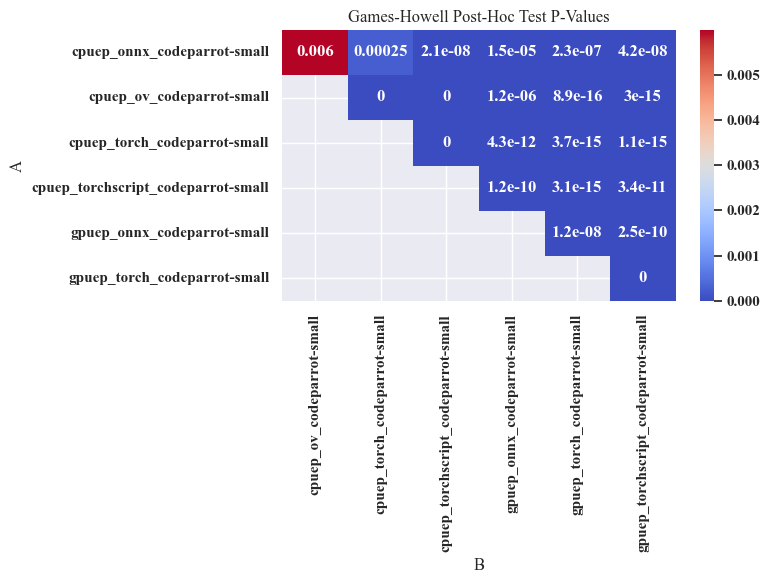

In [101]:


# Performing the Games-Howell test
results = pg.pairwise_gameshowell(data=df, dv=dependent_variable, between=independent_variable)


# Extract the p-values and reshape into a matrix form
p_matrix = results.pivot(index='A', columns='B', values='pval')
print(p_matrix)
# Filling diagonal and lower triangle with NaNs for clarity (optional)
#for i in range(len(p_matrix)):
#    p_matrix.iloc[i, i:] = float('nan')

# Display the p-values matrix
#print("------")
#print(p_matrix)

# Visualizing the matrix
plt.figure(figsize=(8,6))
sns.heatmap(p_matrix, annot=True, cmap='coolwarm', )
plt.title('Games-Howell Post-Hoc Test P-Values')
plt.savefig(save_dir+f"gameshowell_{model}_{dependent_variable}_merged.png") if SAVE_FIGS else print(f"SAVE_FIGS:{SAVE_FIGS}")
plt.show()


In [102]:
p_matrix

B,cpuep_ov_codeparrot-small,cpuep_torch_codeparrot-small,cpuep_torchscript_codeparrot-small,gpuep_onnx_codeparrot-small,gpuep_torch_codeparrot-small,gpuep_torchscript_codeparrot-small
A,,,,,,
cpuep_onnx_codeparrot-small,0.005987,0.000253,2.057648e-08,1.505007e-05,2.292690e-07,4.177615e-08
cpuep_ov_codeparrot-small,NaN,0.000000,0.000000e+00,1.221180e-06,8.881784e-16,2.997602e-15
cpuep_torch_codeparrot-small,NaN,NaN,0.000000e+00,4.287015e-12,3.663736e-15,1.110223e-15
cpuep_torchscript_codeparrot-small,NaN,NaN,NaN,1.213272e-10,3.108624e-15,3.448120e-11
gpuep_onnx_codeparrot-small,NaN,NaN,NaN,NaN,1.238648e-08,2.520243e-10
gpuep_torch_codeparrot-small,NaN,NaN,NaN,NaN,NaN,0.000000e+00


In [103]:
significant_comparisons = p_matrix < 0.05
significant_comparisons

B,cpuep_ov_codeparrot-small,cpuep_torch_codeparrot-small,cpuep_torchscript_codeparrot-small,gpuep_onnx_codeparrot-small,gpuep_torch_codeparrot-small,gpuep_torchscript_codeparrot-small
A,,,,,,
cpuep_onnx_codeparrot-small,True,True,True,True,True,True
cpuep_ov_codeparrot-small,False,True,True,True,True,True
cpuep_torch_codeparrot-small,False,False,True,True,True,True
cpuep_torchscript_codeparrot-small,False,False,False,True,True,True
gpuep_onnx_codeparrot-small,False,False,False,False,True,True
gpuep_torch_codeparrot-small,False,False,False,False,False,True


In [104]:
# Create a DataFrame to display results with 'X' for significant comparisons
result_display = significant_comparisons.applymap(lambda x: 'X' if x else '')

print("Significance Grid (X indicates a significant difference):")
result_display.to_csv(save_dir+f"gameshowell_{model}_{dependent_variable}.csv") if SAVE_TABLES else print(f"SAVE_TABLES:{SAVE_TABLES}")
result_display

Significance Grid (X indicates a significant difference):


B,cpuep_ov_codeparrot-small,cpuep_torch_codeparrot-small,cpuep_torchscript_codeparrot-small,gpuep_onnx_codeparrot-small,gpuep_torch_codeparrot-small,gpuep_torchscript_codeparrot-small
A,,,,,,
cpuep_onnx_codeparrot-small,X,X,X,X,X,X
cpuep_ov_codeparrot-small,,X,X,X,X,X
cpuep_torch_codeparrot-small,,,X,X,X,X
cpuep_torchscript_codeparrot-small,,,,X,X,X
gpuep_onnx_codeparrot-small,,,,,X,X
gpuep_torch_codeparrot-small,,,,,,X
